In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import datetime
from utils.es_utils import *
from utils.env_utils import *
from utils.train_utils import *
import torch.nn.functional as F
from models.Buffer import Buffer
from models.DeepGenerator import GeneratorPolicy
from models.Discriminator import Discriminator
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from models.Buffer import Pool
from utils.env_utils import *
from utils.eval_utils import *

In [2]:
# Training Folder
path = r"..\data\pretuning"
timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
folder_name = f"Pretuning - {timestamp}"

save_dir = os.path.join(path, folder_name)
os.makedirs(save_dir, exist_ok=True)

total_detections = 33
data_path = rf'..\data\processed\pred_prey_interactions\expert_tensors\{total_detections}'
hl_path = rf'..\data\processed\pred_prey_interactions\expert_tensors\hand_labeled'
ftw_path = rf'..\data\processed\pred_prey_interactions\full_track_windows\{total_detections}'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = GeneratorPolicy().to(device)
pred_policy.set_parameters(init=True)

prey_policy = GeneratorPolicy().to(device)
prey_policy.set_parameters(init=True)

expert_buffer = Buffer(pred_max_length=23000, prey_max_length=73000, device=device)

In [4]:
# Load Expert Data from local storage
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(data_path)
expert_buffer.clear(p=80)               # Reduce ratio of non-attack data by 90%. now ~equal
expert_buffer.add_expert(hl_path)       # hand-labeled data | Pred: 1057 | Prey: 33824
expert_buffer.add_expert(hl_path)
len_exp_pred, len_exp_prey = expert_buffer.lengths()

print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  6398
Storage of Prey Expert Buffer:  73000 



In [5]:
def pretrain_policy_with_validation(policy, expert_buffer, role, val_ratio=0.2, pred_bs=256, prey_bs=512, epochs=10, lr=1e-3, device='cpu'):
    # 1) Sample a large batch for BC
    if role == 'predator':
        batch, _ = expert_buffer.sample(pred_bs, prey_bs)
    else:
        _, batch = expert_buffer.sample(pred_bs, prey_bs)

    # 2) Split state and action
    states = batch[..., :4]           # (N, neigh, 4)
    actions = batch[:, 0, 4].squeeze()  # one true action per agent

    # 3) Build dataset and split into train/val
    dataset = TensorDataset(states, actions)
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_ds, batch_size=pred_bs if role=='predator' else prey_bs, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=pred_bs if role=='predator' else prey_bs, shuffle=False)

    # 4) Move model and set up optimizer
    policy.to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    # 5) Training loop with validation
    for epoch in range(1, epochs + 1):
        policy.train()
        total_train_loss = 0.0
        for batch_states, batch_actions in train_loader:
            batch_states = batch_states.to(device)
            batch_actions = batch_actions.to(device)

            if role == 'predator':
                pred_out = policy.forward_pred(batch_states)
            else:
                pred_out = policy.forward_prey(batch_states)

            loss = F.mse_loss(pred_out, batch_actions)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * batch_states.size(0)

        avg_train_loss = total_train_loss / train_size
        train_losses.append(avg_train_loss)

        policy.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for batch_states, batch_actions in val_loader:
                batch_states = batch_states.to(device)
                batch_actions = batch_actions.to(device)

                if role == 'predator':
                    pred_out = policy.forward_pred(batch_states)
                else:
                    pred_out = policy.forward_prey(batch_states)

                loss = F.mse_loss(pred_out, batch_actions)
                total_val_loss += loss.item() * batch_states.size(0)

        avg_val_loss = total_val_loss / val_size
        val_losses.append(avg_val_loss)

        print(f"[{role.upper()}] Epoch {epoch:02d}  Train Loss: {avg_train_loss:.6f}  Val Loss: {avg_val_loss:.6f}")

    # 6) Plot loss curves
    plt.figure()
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f"{role.capitalize()} Loss Curves")
    plt.legend()
    plt.show()

    return policy

[PREDATOR] Epoch 01  Train Loss: 0.461100  Val Loss: 0.517842
[PREDATOR] Epoch 02  Train Loss: 0.450461  Val Loss: 0.341405
[PREDATOR] Epoch 03  Train Loss: 0.465651  Val Loss: 0.478898
[PREDATOR] Epoch 04  Train Loss: 0.451223  Val Loss: 0.501915
[PREDATOR] Epoch 05  Train Loss: 0.479993  Val Loss: 0.431385
[PREDATOR] Epoch 06  Train Loss: 0.451048  Val Loss: 0.500807
[PREDATOR] Epoch 07  Train Loss: 0.450117  Val Loss: 0.410632
[PREDATOR] Epoch 08  Train Loss: 0.467797  Val Loss: 0.402669
[PREDATOR] Epoch 09  Train Loss: 0.441313  Val Loss: 0.397304
[PREDATOR] Epoch 10  Train Loss: 0.430565  Val Loss: 0.426516
[PREDATOR] Epoch 11  Train Loss: 0.454496  Val Loss: 0.421405
[PREDATOR] Epoch 12  Train Loss: 0.444643  Val Loss: 0.424099
[PREDATOR] Epoch 13  Train Loss: 0.469115  Val Loss: 0.412762
[PREDATOR] Epoch 14  Train Loss: 0.439219  Val Loss: 0.447309
[PREDATOR] Epoch 15  Train Loss: 0.448063  Val Loss: 0.472639
[PREDATOR] Epoch 16  Train Loss: 0.424811  Val Loss: 0.415478
[PREDATO

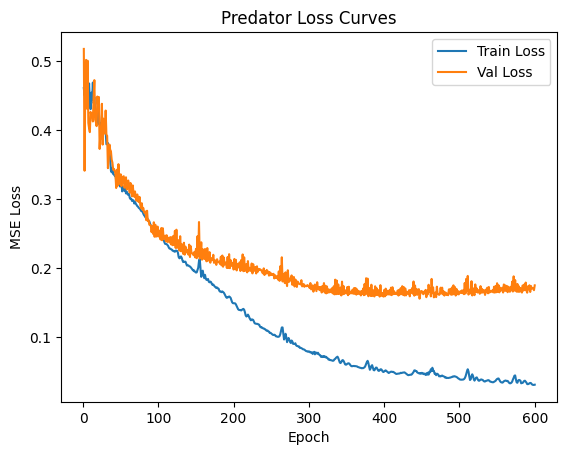

In [6]:
pred_policy = pretrain_policy_with_validation(pred_policy, expert_buffer, role='predator', val_ratio=0.2, pred_bs=1024, prey_bs=2048, epochs=600, lr=1e-3, device='cpu')
torch.save(pred_policy, os.path.join(save_dir, "pred_policy.pt"))

[PREY] Epoch 01  Train Loss: 0.373130  Val Loss: 0.421622
[PREY] Epoch 02  Train Loss: 0.365392  Val Loss: 0.405351
[PREY] Epoch 03  Train Loss: 0.370538  Val Loss: 0.413990
[PREY] Epoch 04  Train Loss: 0.369303  Val Loss: 0.404455
[PREY] Epoch 05  Train Loss: 0.365919  Val Loss: 0.404365
[PREY] Epoch 06  Train Loss: 0.357689  Val Loss: 0.408357
[PREY] Epoch 07  Train Loss: 0.370593  Val Loss: 0.384691
[PREY] Epoch 08  Train Loss: 0.371105  Val Loss: 0.418125
[PREY] Epoch 09  Train Loss: 0.340644  Val Loss: 0.390212
[PREY] Epoch 10  Train Loss: 0.365667  Val Loss: 0.412195
[PREY] Epoch 11  Train Loss: 0.356114  Val Loss: 0.386230
[PREY] Epoch 12  Train Loss: 0.369355  Val Loss: 0.377906
[PREY] Epoch 13  Train Loss: 0.354320  Val Loss: 0.374310
[PREY] Epoch 14  Train Loss: 0.342361  Val Loss: 0.406222
[PREY] Epoch 15  Train Loss: 0.344050  Val Loss: 0.381530
[PREY] Epoch 16  Train Loss: 0.333391  Val Loss: 0.385033
[PREY] Epoch 17  Train Loss: 0.329507  Val Loss: 0.366157
[PREY] Epoch 1

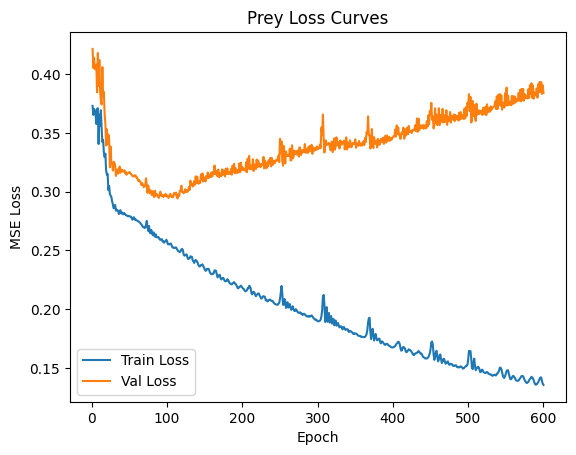

In [7]:
prey_policy = pretrain_policy_with_validation(prey_policy, expert_buffer, role='prey', val_ratio=0.2, pred_bs=1024, prey_bs=2048, epochs=600, lr=1e-3, device='cpu')
torch.save(prey_policy, os.path.join(save_dir, "prey_policy.pt"))

In [8]:
# Expert Data
total_detections=33
ftw_path = rf"..\data\processed\pred_prey_interactions\full_track_windows\{total_detections}"

start_frame_pool = Pool(max_length=12100, device=device)
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

Start frames in pool: 11978


In [10]:
env = parallel_env(predator_count=1, prey_count=32, action_count=360, use_walls=True)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
metrics = run_policies(env, pred_policy, prey_policy)

Press 'q' to end simulation.
